In [33]:
# importing of libaries
import numpy as np                      #functions for scientific computing, faster arrays
import pandas as pd                     #easy import and export of data, fast and easy-to-use datastructure
import math                             #mathematical functions
import matplotlib.pyplot as plt         #generation of Graphs
import seaborn as sns                   #generation of Graphs
import scipy as sci
from scipy.constants import pi, g       #fundamental Constants
import Leistung as lei                  #Eigenes Modul um Leistung und Fahrtwiderstaende zu berechnen 
from sklearn.cluster import KMeans      # Für K mean clustering

In [34]:
# document paths
path_data_idle1 = "data/idle1.csv"
path_data_drive1 = "data/drive1.csv"
path_data_live1 = "data/live1.csv"
path_data_ufpe1 = "data/ufpe1.csv"
path_data_long1 = "data/long1.csv"
graphs ="graphs/"

paths = (path_data_idle1, path_data_drive1, path_data_live1, path_data_ufpe1, path_data_long1)
length = len(paths)
data = list()  #list of pandas Dataframes
names = list() #list of the names of the data sets
for i in range(length):
    data.append(pd.read_csv(paths[i]))
    data[i]["VEHICLE_SPEED ()"] = data[i]["VEHICLE_SPEED ()"]/3.6 #transformation from kmh to m/s
    data[i]["ENGINE_RPM ()"] = data[i]["ENGINE_RPM ()"]/60 #transformieren von rpm zu u/s, name für kompabilitaet beinehalten
    names.append(paths[i][5:-4]) #Abschneiden von data/ und .csv

In [35]:
# Constants
d_wheel = .583 #m Reifendurchmesser
#Source: https://tirewheelguide.de/sizes/toyota/etios-liva/2014/


In [36]:
# Wheel rotation from speed
# pV: speed in m/s
def n_Rad(pV):
    return (pV) / (d_wheel * pi)

In [37]:
for i in range(length):
    data[i]= data[i].assign(N_RAD = data[i]['VEHICLE_SPEED ()'].apply(n_Rad))

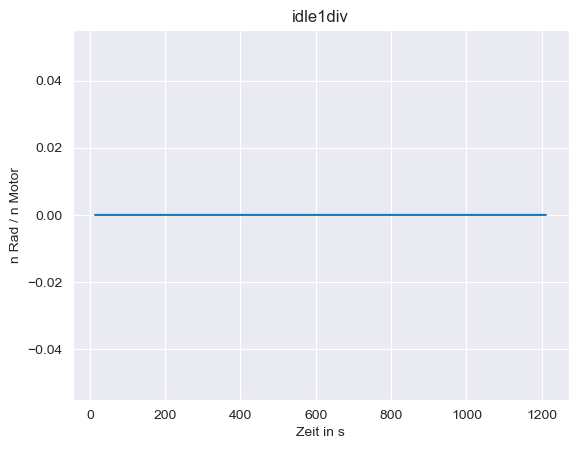

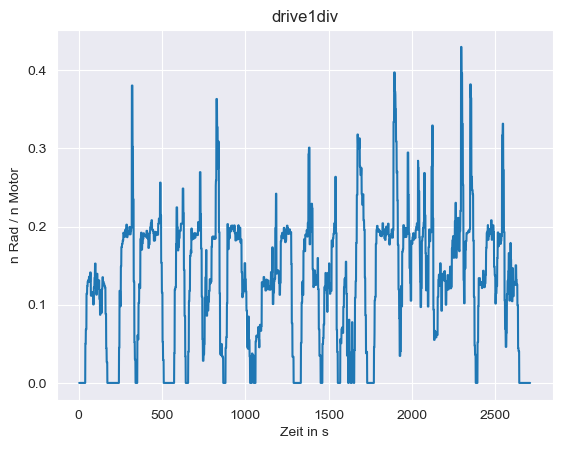

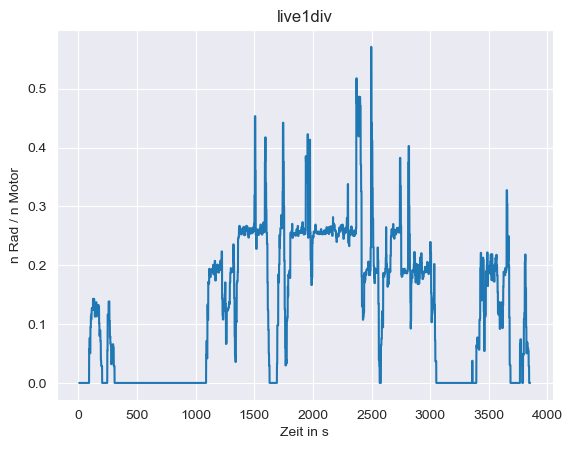

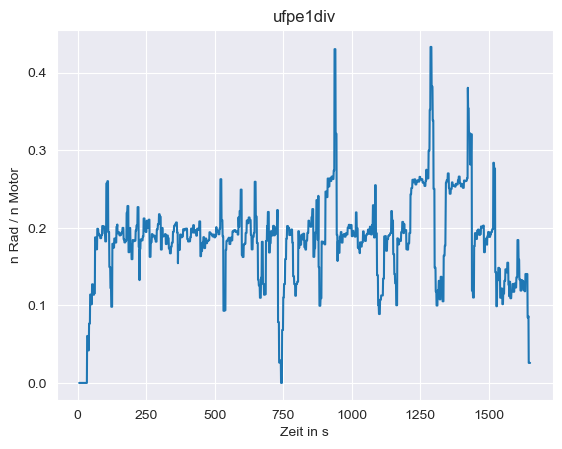

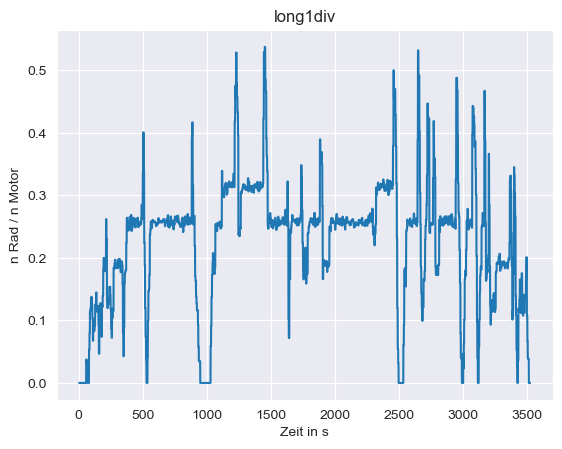

In [38]:
for i in range(length):
    local_length = int(data[i].shape[0])
    div = np.zeros(length)
    div = data[i]["N_RAD"]/data[i]["ENGINE_RPM ()"]
    data[i] = data[i].assign(DIV=div)
    plt.plot(div)
    plt.title(names[i]+"div")
    plt.xlabel("Zeit in s")
    plt.ylabel("n Rad / n Motor")
    plt.savefig(graphs+"div_"+names[i]+".png")
    plt.grid(True)
    plt.show()

weiteres vorgehen für die Bestimmung der Gänge, bereiche in denen sich die Drehzahl länger aufhält finden und für den x bereich den Durchschnitt bilden

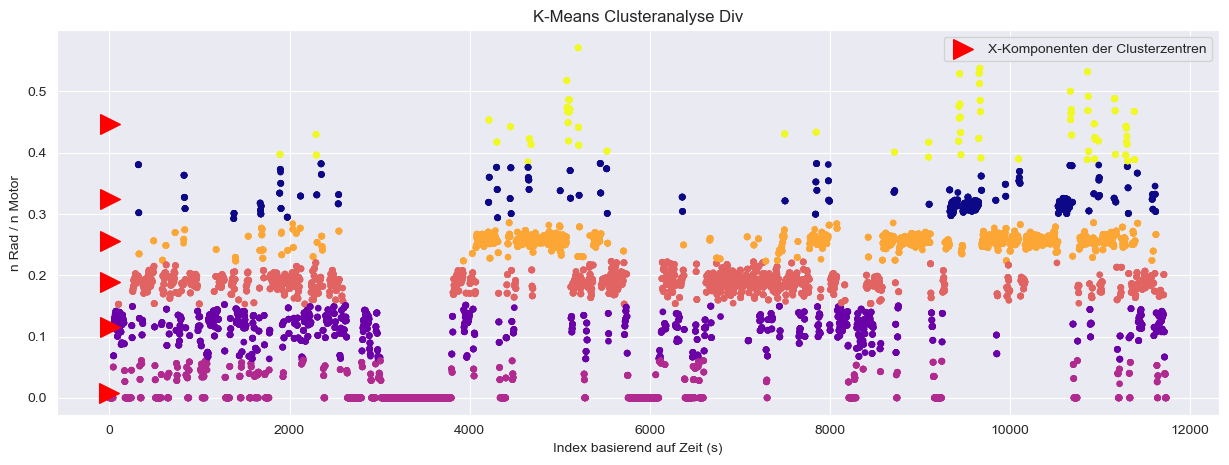

In [39]:
# finden dieser Punkte über K mean Clustering
kmeans = KMeans(n_clusters= 6)
temp = data[1]["DIV"].to_numpy(na_value= 0)
for i in range(2,length):
    temp = np.append(temp,data[i]["DIV"].to_numpy(na_value= 0))
temp= temp.reshape(-1,1)
kmeans.n_init = 300
kmeans.fit(temp)
# Erhalte die zugeordneten Clusterzentren und die Zuordnung der Datenpunkte zu den Clustern
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

labels
# Visualisiere die Cluster
u_labels = np.unique(labels)
plt.figure(figsize=(15, 5))
plt.scatter(np.arange(len(temp)),temp[:,0], c=labels, s=15, cmap='plasma')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 0], marker='>', s=200, color='red', label="X-Komponenten der Clusterzentren")
plt.title('K-Means Clusteranalyse Div')
plt.xlabel('Index basierend auf Zeit (s)')
plt.ylabel("n Rad / n Motor")
plt.legend()
plt.savefig(graphs+"kmeans.png",dpi=300)
plt.show()


In [40]:
# zuordnen und sortieren der cluster zu den gaengen
clus = pd.DataFrame(cluster_centers, columns=['center'])
clus = clus.assign(label=np.arange(len(cluster_centers)))
clus = clus.sort_values(by='center')
clus = clus.assign(gang=np.arange(len(cluster_centers)))
# zuordnung der Gaenge zu den Punkten, erste beiden CLuster werden dem 1. Gang zugeordnet
gaenge = np.zeros(len(labels))
for i in range(len(gaenge)):
    gang = clus["gang"][labels[i]] #zuordnung über ausnutzung des index
    if 0 == gang: 
        gaenge[i] = 1                   #zuordnung des ersten ganges für untersten bereich
    else: 
        gaenge[i] = gang
# Uebertragen auf dataframes
for i in range(1, length): # 1, da leerlauf nicht betrachtet
    data[i] = data[i].assign(GANG=gaenge[:int(data[i].shape[0])]) #nur bis laenge des jeweiligen dataframes
    gaenge = gaenge[int(data[i].shape[0]) :] #loeschen des zugeordneten bereiches

In [41]:
# Uebersetzung bestimmen i = i_A \cdot i_G
clus = clus.assign(uebersetzungsverhaeltnis = 1/clus["center"]) # wert fuer 0 ohne bedeutung
# loeschen der saeulen fuer den Export
clus = clus.drop("center", axis=1)
clus = clus.drop("label", axis=1)
clus.to_latex("clus.txt") #ausgabe als Tabelle in Latex

## Beschleunigung

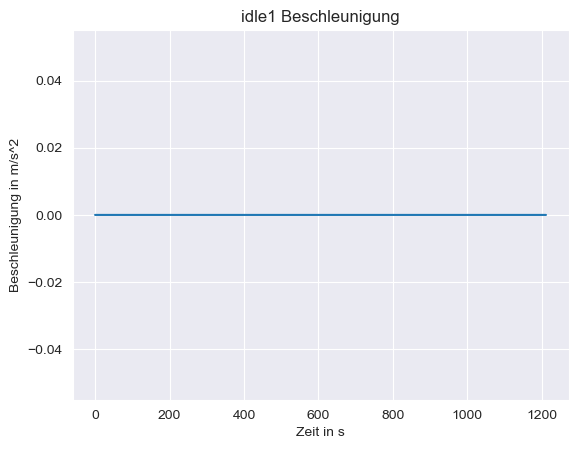

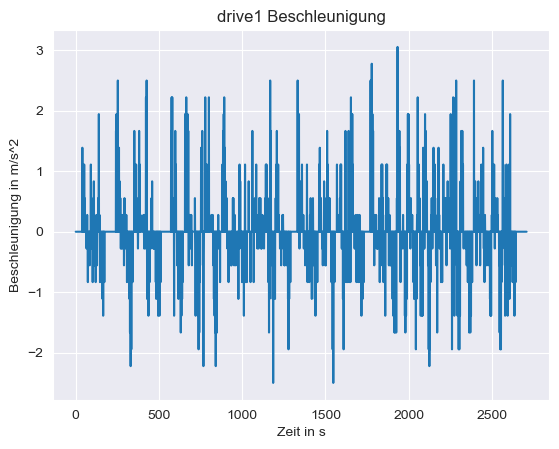

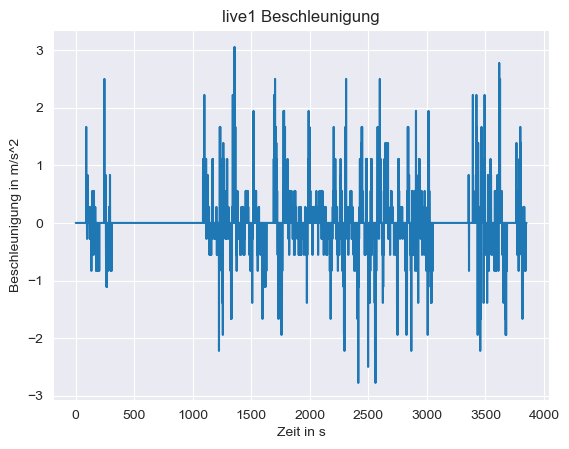

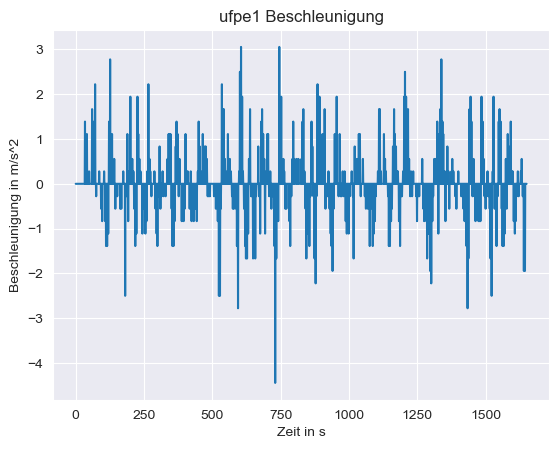

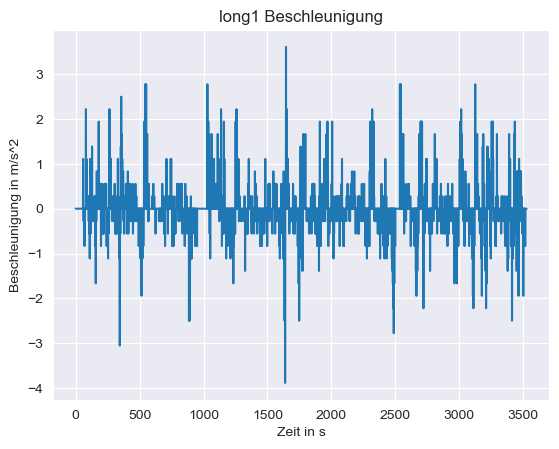

In [42]:
for i in range(length):   
    local_length = int(data[i].shape[0])
    acc =np.zeros(local_length)
    for j in range(local_length-1):
        acc[j]=data[i]["VEHICLE_SPEED ()"][j+1]-data[i]["VEHICLE_SPEED ()"][j] #teilen durch Zeit entfällt, da delta t = 1s
    
    data[i] = data[i].assign(BESCHLEUNIGUNG =acc)
    plt.plot(acc)
    plt.title(names[i]+" Beschleunigung")
    plt.xlabel("Zeit in s")
    plt.ylabel("Beschleunigung in m/s^2")
    plt.grid(True)
    plt.savefig(graphs+"beschleunigung_"+names[i]+".png",dpi=300)
    plt.show()

## Power

In [43]:

def leistung_1(pDataframe):
    laenge = int(pDataframe.shape[0]) #Bestimmung der Laenge des Dataframes
    leist = np.zeros(laenge)
    for i in range(laenge-1):
        leist[i] = lei.leistung_1(pDataframe["VEHICLE_SPEED ()"][i],pDataframe["BESCHLEUNIGUNG"][i],0)
    return leist

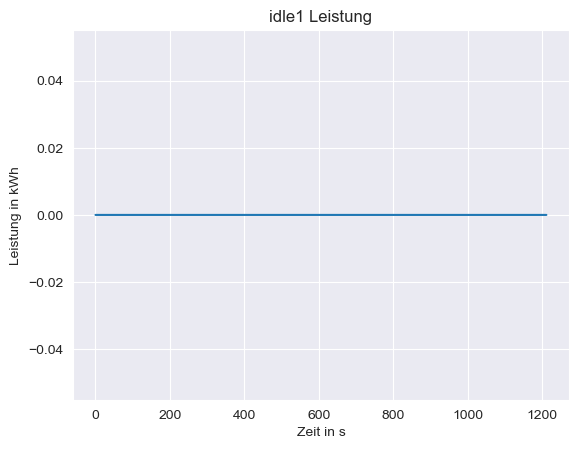

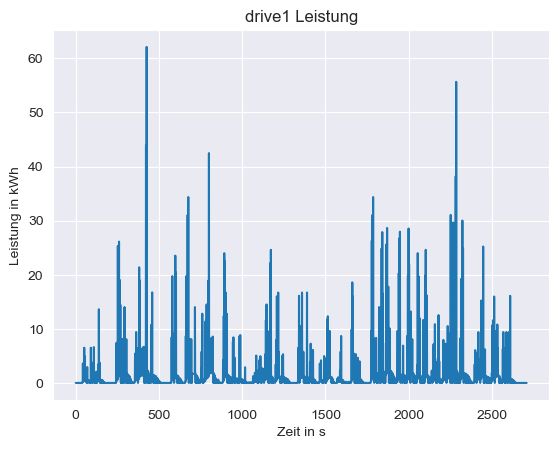

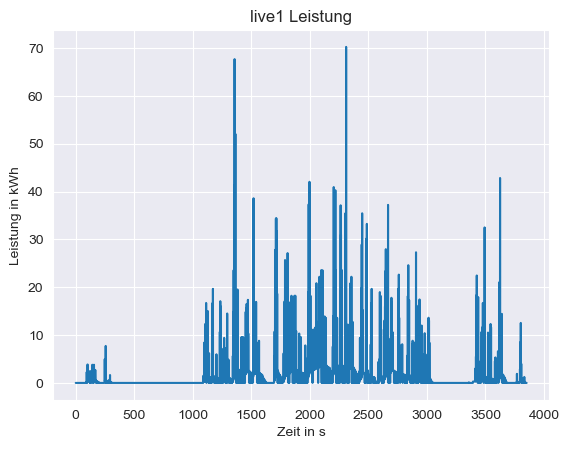

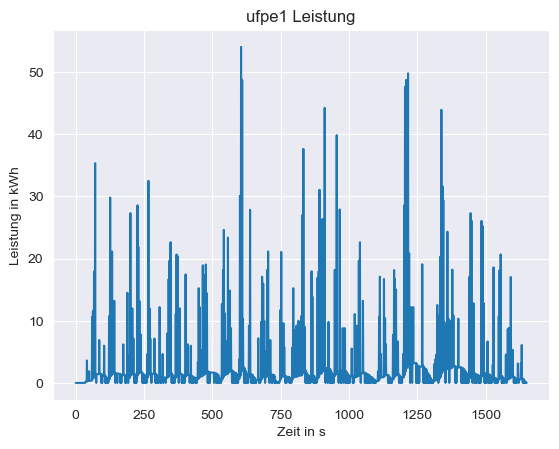

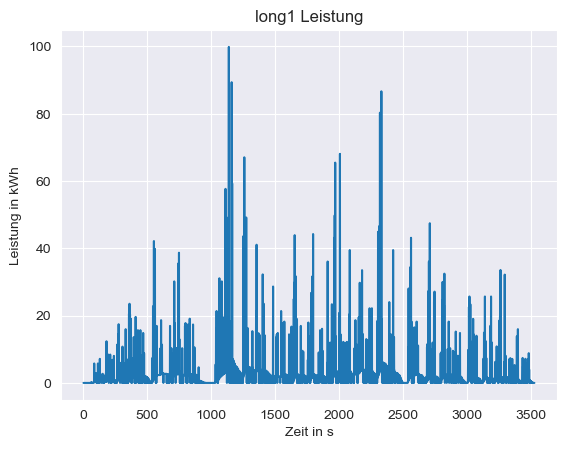

In [44]:
for i in range(length):
    local_length = int(data[i].shape[0])
    leist = np.zeros(local_length)
    for j in range(local_length-1):
        leist[j] = lei.leistung_1(data[i]["VEHICLE_SPEED ()"][j],data[i]["BESCHLEUNIGUNG"][j],0) #Funktion zur Berechnung der Aktuellen Leistung
    data[i] = data[i].assign(LEISTUNG=leist)
    plt.plot(leist/1000)
    plt.title(names[i]+" Leistung")
    plt.xlabel("Zeit in s")
    plt.ylabel("Leistung in kWh")
    plt.grid(True)
    plt.savefig(graphs+"leistung_"+names[i]+".png",dpi=300)
    plt.show()

## Drehmoment

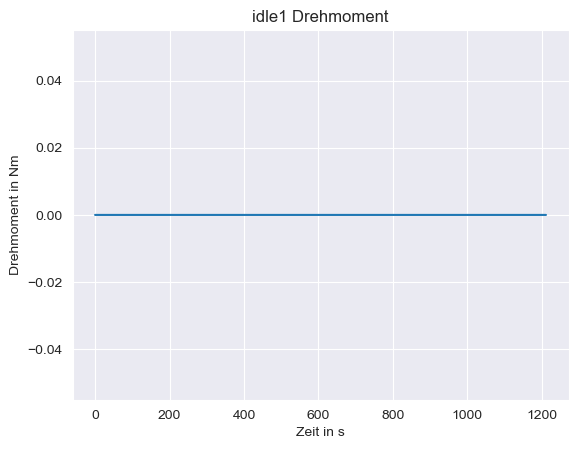

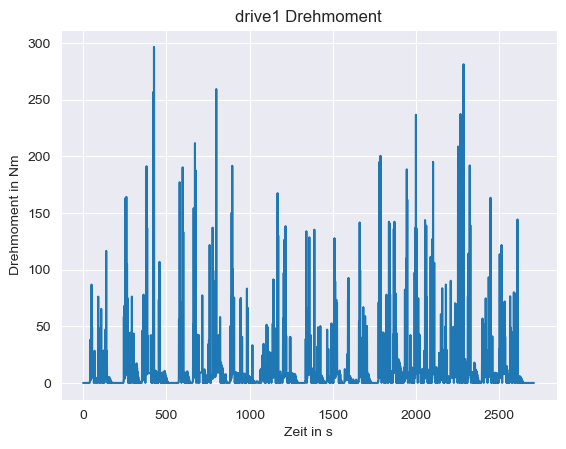

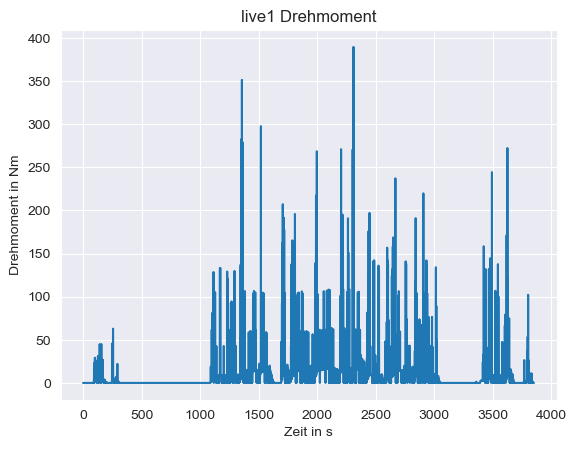

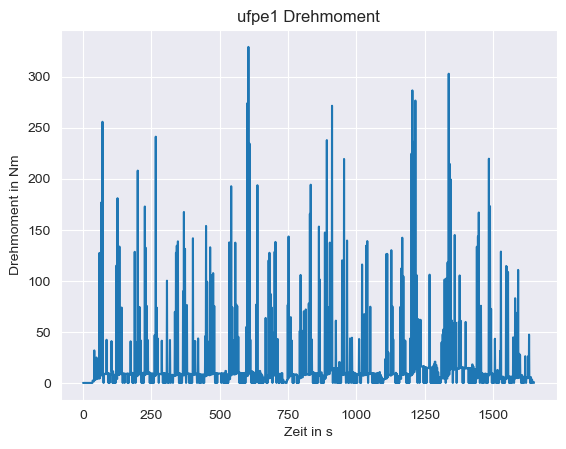

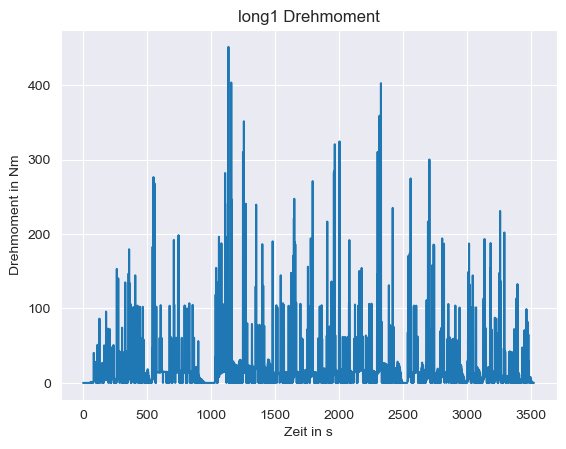

In [45]:
# Berechnung des Drehmomentes aus Leistung und RPM
# Aktuell werden gänge noch nicht berücksichtigt
for i in range(length):
    local_length = int(data[i].shape[0])
    drehM = np.zeros(local_length)
    for j in range(local_length-1):
        if 0 != data[i]["ENGINE_RPM ()"][j]:
            drehM[j] = (data[i]["LEISTUNG"][j]*9.550)/((data[i]["ENGINE_RPM ()"][j]*60))
        else:            #für den Fall das n = 0, ist die Formel oben nicht definiert, da der Motor in diesem Fall steht wird M = 0 gesetzt
            drehM[j] = 0
    data[i] = data[i].assign(DREHMOMENT=drehM)
    #temp_data = data[i].sort_values(by=["N_RAD"])
    #temp_data = temp_data.drop(temp_data[temp_data["LEISTUNG"]==0].index)
    plt.plot(data[i]["DREHMOMENT"])
    plt.title(names[i]+" Drehmoment")
    plt.xlabel("Zeit in s")
    plt.ylabel("Drehmoment in Nm")
    plt.grid(True)
    plt.savefig(graphs+"drehmoment_"+names[i]+".png",dpi=300)
    plt.show()

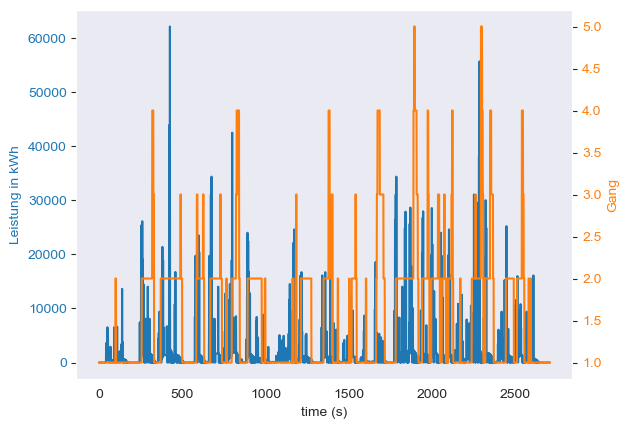

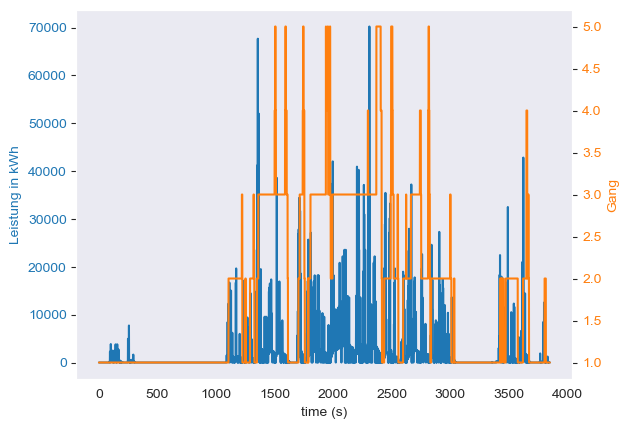

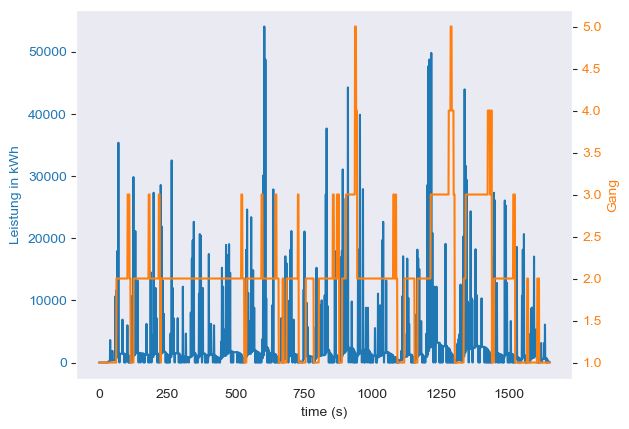

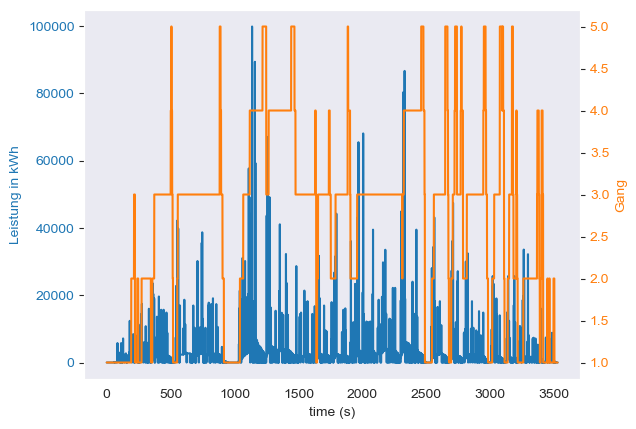

In [46]:
# Leistung und Gang
for i in range (1,length):
    fig, ax1 = plt.subplots()
    
    color = "tab:blue"
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Leistung in kWh', color=color)
    ax1.plot(data[i]["LEISTUNG"], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid(False)

    ax2 = ax1.twinx()  

    color = 'tab:orange'
    ax2.set_ylabel('Gang', color=color)  
    ax2.plot(data[i]["GANG"], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.grid(False)
    plt.savefig(graphs+"drehmoment_Gang_"+names[i]+".png",dpi=300)
    plt.show()

## Ausgabe

In [47]:
for i in range(length):
    data[i].to_csv("data/v2_"+names[i]+".csv")
    data[i].to_excel("data/v2_"+names[i]+".xlsx")

In [48]:
# output of key values
dauer = np.zeros(length) # in s
max_geschwindigkeit = np.zeros(length) # in km/h
max_beschleunigung = np.zeros(length) # in m/s^2
min_beschleunigung = np.zeros(length) # in m/s^2
max_Leistung = np.zeros(length) #in kW
max_Drehmoment = np.zeros(length) #in Nm
for i in range(length):
    dauer[i] = int(data[i].shape[0])
    max_geschwindigkeit[i] = round(data[i]["VEHICLE_SPEED ()"].max(),2)
    max_beschleunigung[i] = round(data[i]["BESCHLEUNIGUNG"].max(),2)
    min_beschleunigung[i] = round(data[i]["BESCHLEUNIGUNG"].min(),2)
    max_Leistung[i] =  round(data[i]["LEISTUNG"].max()/1000,2)
    max_Drehmoment[i] = round(data[i]["DREHMOMENT"].max(),2)

output = pd.DataFrame({"Name": names,
                        "Dauer in s": dauer,
                       "max Geschwindigkeit in m/s": max_geschwindigkeit,
                       "max Geschwindigkeit in km/h":max_geschwindigkeit*3.6,
                       "max Beschleunigung in m/s^2": max_beschleunigung,
                       "min Beschleunigung im m/s^2": min_beschleunigung,
                       "max Leistung in kW": max_Leistung,
                       "max Drehmoment in Nm": max_Drehmoment}
                      ,index = names)
output.to_excel("output.xlsx")
output.to_latex("output.tex",index=False)
output

,Name,Dauer in s,max Geschwindigkeit in m/s,max Geschwindigkeit in km/h,max Beschleunigung in m/s^2,min Beschleunigung im m/s^2,max Leistung in kW,max Drehmoment in Nm
idle1,idle1,1212.0,0.00,0.000,0.00,0.00,0.00,0.00
drive1,drive1,2709.0,13.33,47.988,3.06,-2.50,62.11,296.48
live1,live1,3853.0,16.67,60.012,3.06,-2.78,70.22,389.50
ufpe1,ufpe1,1651.0,15.00,54.000,3.06,-4.44,54.04,328.97
long1,long1,3528.0,22.50,81.000,3.61,-3.89,99.85,451.39
